In [1]:
import numpy as np
import cv2
import sys
import time
import os.path
import matplotlib.pyplot as plt
# from dataPath import DATA_PATH
# from dataPath import MODEL_PATH
DATA_PATH = "/home/david/Pictures/test_images/"
MODEL_PATH = "/home/david/PycharmProjects/opencv/course1/neural_network/"
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0,15.0)
matplotlib.rcParams['image.cmap'] = 'gray'

# start measuring time
start = time.time()

In [3]:
# Initialize the parameters
objectnessThreshold = 0.5 # Objectness threshold (Threshold determining if something is obj)
confThreshold = 0.5       # Confidence threshold (how conf about it being an obj)
nmsThreshold = 0.4        # Non-maximum suppression threshold (same obj detected multi times)
inpWidth = 416            # Width of network's input image (larger sizes = more accurate)
inpHeight = 416           # Height of network's input image (..but take more time)

In [4]:
# Load names of classes
classesFile = MODEL_PATH + "coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = MODEL_PATH + "yolov3.cfg"
modelWeights = MODEL_PATH + "yolov3.weights"

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)

In [5]:
# Get the names of the output layers
# There are 3 layers in YOLOv3 and only the last one does not have a name
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [6]:
# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom):
    cv2.rectangle(
        frame, 
        (left, top), 
        (right, bottom), 
        (255, 178, 50), 
        1)
    label = conf * 100
    if classes: 
        assert(classId < len(classes))
        label = f'{classes[classId]}: {label:.0f}%'
    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(
        label, 
        cv2.FONT_HERSHEY_COMPLEX_SMALL, 
        1, 
        1)
    top = max(top, labelSize[1])
    cv2.rectangle(
        frame, 
        (left, top - labelSize[1]), 
        (right, top + baseLine), 
        (255, 178, 50), 
        cv2.FILLED)
    cv2.putText(
        frame, 
        label, 
        (left + 15, top), 
        cv2.FONT_HERSHEY_COMPLEX_SMALL, 
        0.5, 
        (255, 255, 255), 
        thickness=1, 
        lineType=1)

In [7]:
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    classIds = []
    confidences = []
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            if detection[4] > objectnessThreshold :
                scores = detection[5:]
                classId = np.argmax(scores)
                confidence = scores[classId]
                if confidence > confThreshold:
                    center_x = int(detection[0] * frameWidth)
                    center_y = int(detection[1] * frameHeight)
                    width = int(detection[2] * frameWidth)
                    height = int(detection[3] * frameHeight)
                    left = int(center_x - width / 2)
                    top = int(center_y - height / 2)
                    classIds.append(classId)
                    confidences.append(float(confidence))
                    boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height)

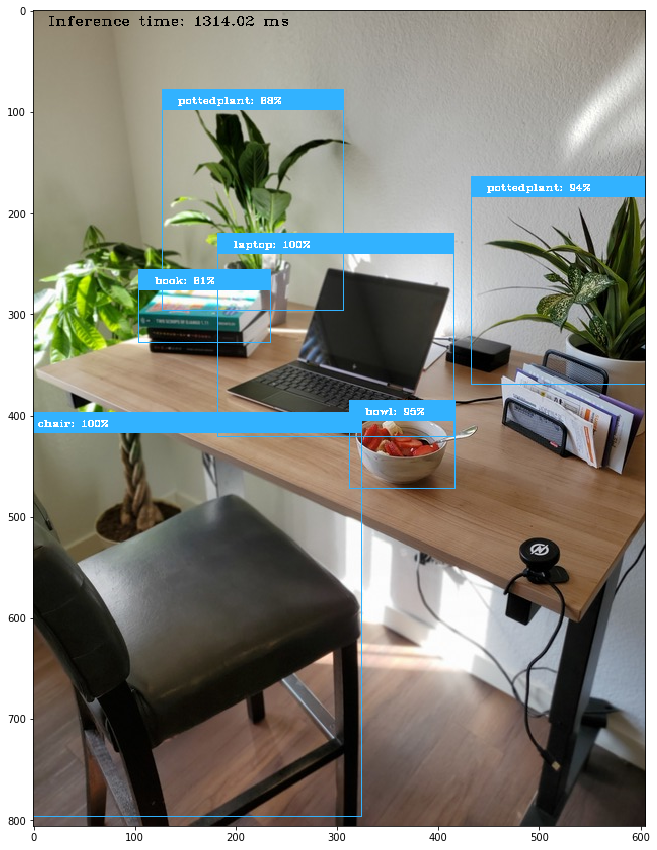

Inference time: 1314.02 ms
2.826430559158325


In [8]:
# Process inputs
imagePath = DATA_PATH + "desk_small.jpg"
frame = cv2.imread(imagePath)

# Create a 4D blob from a frame.
blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

# Sets the input to the network
net.setInput(blob)

# Runs the forward pass to get output of the output layers
outs = net.forward(getOutputsNames(net))
#outs = net.forward()

# Remove the bounding boxes with low confidence
postprocess(frame, outs)

# Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (15, 15), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.7, (0, 0, 0))

plt.imshow(frame[...,::-1])
plt.show()
print(label)
end = time.time() - start
print(end)